In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()



In [12]:
#data = engine.execute("SELECT * FROM ")
#for record in data:
   # print(record)


In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Results = session.query(Measurement.date, Measurement.prcp) .filter(Measurement.date>'2016-08-23').all()
#Results
# Calculate the date 1 year ago from the last data point in the database
Previous_year_date= dt.date(2017,8,23) - dt.timedelta(days= 365)
# Perform a query to retrieve the data and precipitation scores
Results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= Previous_year_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
DF =  pd.DataFrame(Results, columns=['date', 'precipitation'])
DF.set_index(DF['date'], inplace=True)
# Sort the dataframe by date

DF= DF.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data

#plt.plot(DF['date'], DF['precipitation'], color = 'blue', label = 'precipitation')
#plt.xlabel("date")
#plt.legend(loc= 'best')

#plt.ylim(0 ,7)
#plt.figure(figsize= (10, 10 ))
#plt.show()
#DF.plot(x_compat= True)
DF.head()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  del sys.path[0]


,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15


![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
DF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [19]:
#Design a query to show how many stations are available in this dataset?
#stationdata = Station(engine, reflect=True)
#print(stationdata.tables)
session.query(func.count(Station.station)).all()


[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

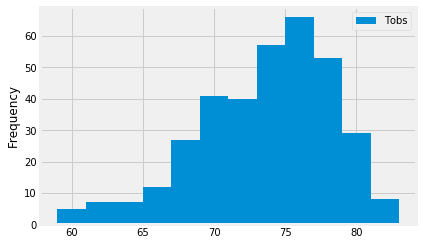

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp_observe = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281')\
.filter(Measurement.date>='2016-08-23').all()
Temp_observe = pd.DataFrame(Temp_observe, columns=['Tobs'])
Temp_observe.head(5)
Temp_observe.plot.hist(bins=12)
plt.legend(loc= 'best')
plt.ylabel("Frequency")
#plt.xlabel("Test")
plt.show()

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print (calc_temps('2011-02-28', '2011-03-05'))


[(61.0, 69.75510204081633, 75.0)]


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vaca = (calc_temps('2011-02-28', '2011-03-05'))
vaca =pd.DataFrame(vaca, columns=['Tmin', 'Tavg', 'Tmax'])



In [57]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [58]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
